<a href="https://colab.research.google.com/github/vicben2/hgraph2graph/blob/main/Partb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/wengong-jin/hgraph2graph

fatal: destination path 'hgraph2graph' already exists and is not an empty directory.


In [4]:
%cd hgraph2graph

/content/hgraph2graph


In [12]:
!pip install rdkit networkx tqdm
import torch
from torch.utils.data import DataLoader
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, DataStructs
from rdkit import DataStructs
from hgraph import HierVAE, MolGraph, common_atom_vocab, Vocab, PairVocab
from hgraph import MoleculeDataset
import sys
import os

In [28]:
class Args:
  def __init__(self):
    self.vocab = None
    self.atom_vocab = common_atom_vocab
    self.rnn_type = 'LSTM'
    self.hidden_size = 250
    self.embed_size = 250
    self.batch_size = 20
    self.latent_size = 32
    self.depthT = 15
    self.depthG = 15
    self.diterT = 1
    self.diterG = 3
    self.dropout = 0.0

args = Args()

seed = 7

torch.manual_seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#vocab
vocab_path = 'data/chembl/vocab.txt'
vocab_list = [x.strip("\r\n ").split() for x in open(vocab_path)] # Renamed to vocab_list to avoid confusion
args.vocab = PairVocab(vocab_list, cuda=(device.type == 'cuda')) # FIX: Explicitly pass cuda argument

def filter_for_vocab(smiles_list, vocab):
    valid_smiles = []

    for smi in tqdm(smiles_list, desc="Vocab processing"):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                print(f"Skipping invalid SMILES (MolFromSmiles failed): {smi}")
                continue

            try:
                Chem.Kekulize(mol, clearAromaticFlags=False)
            except Exception as e:
                print(f"Skipping SMILES due to Kekulization error: {smi} - {e}")
                continue

            try:
                hmol = MolGraph(smi)
            except Exception as e:
                print(f"Skipping SMILES due to MolGraph error: {smi} - {e}")
                continue

            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                if attr['label'] not in vocab.vmap:
                    # print(f"Skipping SMILES due to missing label in vocab: {smi} - Label: {attr['label']}")
                    ok = False
                    break
                for i, s in attr['inter_label']:
                    if (smiles_node, s) not in vocab.vmap:
                        # print(f"Skipping SMILES due to missing inter_label in vocab: {smi} - Inter-label: {(smiles_node, s)}")
                        ok = False
                        break
                if not ok:
                    break
            if ok:
                valid_smiles.append(smi)
        except Exception as e:
            print(f"Skipping SMILES due to general error in filter: {smi} - {e}")
            continue

    return valid_smiles

with open('all.txt', 'r') as f:
    all_smiles = [line.strip() for line in f if line.strip()]

print(len(all_smiles))

candidate_smiles = all_smiles[:5000]
valid_smiles = filter_for_vocab(candidate_smiles, args.vocab) # Changed vocab to args.vocab

print(len(valid_smiles))

#splitting
TEST_SIZE = 200
TRAIN_SIZE = min(2000, len(valid_smiles) - TEST_SIZE)
train_smiles = valid_smiles[:TRAIN_SIZE]
test_smiles = valid_smiles[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

with open('train_final.txt', 'w') as f:
    f.write('\n'.join(train_smiles))
with open('test_final.txt', 'w') as f:
    f.write('\n'.join(test_smiles))

5000


Vocab processing:   1%|          | 41/5000 [00:00<00:51, 96.41it/s]

Skipping SMILES due to MolGraph error: CC1=C(C(=O)Nc2ccccc2)C(c2ccc[nH]2)n2ncnc2N1 - Can't kekulize mol.  Unkekulized atoms: 22


Vocab processing:   1%|▏         | 63/5000 [00:00<00:49, 99.65it/s]

Skipping SMILES due to MolGraph error: COc1ccc2c(c1)sc1nc(-c3ccc(NC(C)=O)cc3)cn12 - Can't kekulize mol.  Unkekulized atoms: 5 6 9
Skipping SMILES due to MolGraph error: COc1ccc(N2CCN(C(=O)CCc3nnc4ccc(N5CCC(C)CC5)nn34)CC2)cc1 - Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 28


Vocab processing:   2%|▏         | 75/5000 [00:00<00:46, 105.29it/s]

Skipping SMILES due to MolGraph error: FC(F)Oc1ccc(C=Nc2c(-c3ccc(OC(F)F)cc3)nc3n2CCS3)cc1 - Can't kekulize mol.  Unkekulized atoms: 23
Skipping SMILES due to MolGraph error: O=c1nc(OCC2COCCO2)cc2n1CCc1cc(COC3CCCCC3)ccc1-2 - Can't kekulize mol.  Unkekulized atoms: 13 17 18 19 28 29 30
Skipping SMILES due to MolGraph error: O=C1c2cccc3c(Cl)ccc(c23)C(=O)N1Cc1ccc(S(=O)(=O)N2CCOCC2)cc1 - Can't kekulize mol.  Unkekulized atoms: 2 11 12


Vocab processing:   2%|▏         | 96/5000 [00:01<01:02, 78.80it/s]

Skipping SMILES due to MolGraph error: O=c1c(-c2cccs2)nnc2n1CCN2c1ccc(Cl)cc1 - Can't kekulize mol.  Unkekulized atoms: 10
Skipping SMILES due to MolGraph error: CCc1nc2c(OCc3ccc(C#N)cc3)cccn2c1N(C)C(=O)C(C)C - Can't kekulize mol.  Unkekulized atoms: 4 5 16 17 18
Skipping SMILES due to MolGraph error: CCC(O)(C(=O)O)c1cc2n(c(=O)c1CO)Cc1cc3c(N)c4c(cc3nc1-2)OCO4 - Can't kekulize mol.  Unkekulized atoms: 9 17 27
Skipping SMILES due to MolGraph error: CCCSC(=O)COC(=O)c1c2c3ccc(SCCC)c4cccc(c-2nc1=O)c43 - Can't kekulize mol.  Unkekulized atoms: 12 24 29


Vocab processing:   3%|▎         | 136/5000 [00:01<01:18, 62.34it/s]

Skipping SMILES due to MolGraph error: c1ccc(C2=Nn3cnnc3SC2)cc1 - Can't kekulize mol.  Unkekulized atoms: 10
Skipping SMILES due to MolGraph error: CN(C)c1ccc(-c2cn3cc(Cl)ncc3n2)cc1 - Can't kekulize mol.  Unkekulized atoms: 10 11 13 14 15


Vocab processing:   4%|▍         | 210/5000 [00:02<01:20, 59.77it/s]

Skipping SMILES due to MolGraph error: Cc1cccc(C)c1NC(=O)CN1CCN(C(=O)c2ccc(OCc3cn4ccccc4n3)cc2)CC1 - Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
Skipping SMILES due to MolGraph error: Cc1c(C(=O)Nc2ccccc2-c2cn3ccccc3n2)cnn1-c1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19


Vocab processing:   5%|▍         | 236/5000 [00:03<01:02, 75.92it/s]

Skipping SMILES due to MolGraph error: c1ccc(-c2cccn3nc(Nc4ccc5c(c4)CCNCC5)nc23)c(OCC2CC2)c1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 24
Skipping SMILES due to MolGraph error: CCCc1nc(C)cc(N2CCn3nc(CCC(=O)NC4CC4)cc3C2)n1 - Can't kekulize mol.  Unkekulized atoms: 24


Vocab processing:   5%|▌         | 262/5000 [00:03<00:48, 97.15it/s]

Skipping SMILES due to MolGraph error: CCCN1CCOC2c3cccc4[nH]cc(c34)CC21 - Can't kekulize mol.  Unkekulized atoms: 8 15 16
Skipping SMILES due to MolGraph error: O=c1c2c([nH]c3nc(CCc4ccccc4)nn13)CCC2 - Can't kekulize mol.  Unkekulized atoms: 2 3 5
Skipping SMILES due to MolGraph error: O=C(c1ccc(Cl)cc1Cl)N1CCn2c(nc(C(F)(F)F)c2-c2ccc(F)cc2)C1 - Can't kekulize mol.  Unkekulized atoms: 14


Vocab processing:   6%|▋         | 318/5000 [00:03<00:44, 106.40it/s]

Skipping SMILES due to MolGraph error: Oc1ccccc1-c1nc2cnccn2c1NCc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


Vocab processing:   8%|▊         | 377/5000 [00:04<00:41, 110.91it/s]

Skipping SMILES due to MolGraph error: c1nnc2c3c4c(sc3ncn12)CCC4 - Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
Skipping SMILES due to MolGraph error: Cc1nc2ncnn2c(C)c1Cc1cccc(C(F)(F)F)c1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 8 10
Skipping SMILES due to MolGraph error: Cc1cccc(-c2nc(C3CN(Cc4ccc(-c5nc6nc(-c7ccccn7)nn6c(NC(C)C)c5-c5ccccc5)cc4)C3)n[nH]2)n1 - Can't kekulize mol.  Unkekulized atoms: 17 18 19 30 35


Vocab processing:   8%|▊         | 422/5000 [00:04<00:45, 99.99it/s] 

Skipping SMILES due to MolGraph error: CN1CCN(c2cccc(Nc3nc4cncc(-c5ccc(S(C)(=O)=O)cc5)n4n3)c2)CC1 - Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
Skipping SMILES due to MolGraph error: O=C(CSc1n[nH]c2c3ccccc3nc-2n1)NC1CCCCC1 - Can't kekulize mol.  Unkekulized atoms: 4 5 7 15 16


Vocab processing:   9%|▉         | 445/5000 [00:05<00:43, 104.99it/s]

Skipping SMILES due to MolGraph error: Cc1onc(-c2ccccc2)c1COc1ccc(C(=O)N2CCCn3nccc32)cn1 - Can't kekulize mol.  Unkekulized atoms: 28
Skipping SMILES due to MolGraph error: CC(C)OCCCNC(=O)C(=O)Nc1ccc2nc3n(c(=O)c2c1)CCCCC3 - Can't kekulize mol.  Unkekulized atoms: 18
Skipping SMILES due to MolGraph error: Cc1ccc(C2(c3nnc4n3CCCCCC4)CCC2)cc1 - Can't kekulize mol.  Unkekulized atoms: 9


Vocab processing:  10%|▉         | 491/5000 [00:05<00:41, 108.10it/s]

Skipping SMILES due to MolGraph error: Nc1nc(NCC2CCCN2Cc2c(F)cc(F)cc2F)nc2nc(-c3ccco3)nn12 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
Skipping SMILES due to MolGraph error: Cc1nn(CC(=O)NCCCN2CCN(C)CC2)c(=O)c2cc(-c3ccccc3)nn12 - Can't kekulize mol.  Unkekulized atoms: 1 2 20


Vocab processing:  10%|█         | 525/5000 [00:05<00:42, 104.32it/s]

Skipping SMILES due to MolGraph error: COc1ccc2c3ncn(CCN(C)C)c(O)c-3nc2c1 - Can't kekulize mol.  Unkekulized atoms: 6 7 8 15 17
Skipping SMILES due to MolGraph error: N#Cc1ccc(OCc2cccn3c(=O)cc(N4CCOCC4)nc23)cc1 - Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 24
Skipping SMILES due to MolGraph error: Cc1nc(CC2CCN(C(=O)CCc3cc4n(n3)CCCNC4)CC2)no1 - Can't kekulize mol.  Unkekulized atoms: 15


Vocab processing:  11%|█         | 562/5000 [00:06<00:41, 107.23it/s]

Skipping SMILES due to MolGraph error: Cc1ccc(C)c(CSc2nnc3[nH]c(=O)cc(-c4ccccc4)n23)c1 - Can't kekulize mol.  Unkekulized atoms: 12 16 17
Skipping SMILES due to MolGraph error: CCOc1ccc(CCNC(=O)CCCn2c(=O)c3cccn3c3ccccc32)cc1 - Can't kekulize mol.  Unkekulized atoms: 18 23 28


Vocab processing:  12%|█▏        | 596/5000 [00:06<00:43, 100.79it/s]

Skipping SMILES due to MolGraph error: Cn1c(=O)c2c(nc3[nH]c(-c4ccccc4)cn32)n(C)c1=O - Can't kekulize mol.  Unkekulized atoms: 7 9 16


Vocab processing:  13%|█▎        | 635/5000 [00:06<00:40, 108.84it/s]

Skipping SMILES due to MolGraph error: COCCN1CCn2cc(CNC(=O)C3CCC3)nc2C1 - Can't kekulize mol.  Unkekulized atoms: 19
Skipping SMILES due to MolGraph error: CCc1cc2c(C3=NNC(=O)C3(C)C)ccc(C)n2n1 - Can't kekulize mol.  Unkekulized atoms: 4 5 14 15 16
Skipping SMILES due to MolGraph error: Cc1c2c3ccccc3nc-2[nH]c2ccccc12 - Can't kekulize mol.  Unkekulized atoms: 1 2 10 12 17


Vocab processing:  14%|█▎        | 680/5000 [00:07<00:43, 99.60it/s]

Skipping SMILES due to MolGraph error: Cc1ccnc(-c2c(C(C)Nc3ncnc(N)c3C#N)nc3ccccn3c2=O)c1 - Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
Skipping SMILES due to MolGraph error: CC(C)(C)c1cc(=O)n2nc(-c3ccc(F)cc3)cc2[nH]1 - Can't kekulize mol.  Unkekulized atoms: 4 5 19
Skipping SMILES due to MolGraph error: COc1ccc(NC(=O)Cn2ncn3nc(-c4ccc(OC)cc4)cc3c2=O)cc1 - Can't kekulize mol.  Unkekulized atoms: 11 12 25
Skipping SMILES due to MolGraph error: Cc1cn2c(=O)cc(COc3ccccc3NC(=O)c3ccc(C(C)(C)C)cc3)nc2s1 - Can't kekulize mol.  Unkekulized atoms: 1 2 30


Vocab processing:  14%|█▍        | 714/5000 [00:07<00:41, 104.06it/s]

Skipping SMILES due to MolGraph error: CCc1nc2ccc(C(=O)Nc3ccc(OC)c(OC)c3)cn2c1N(CCC(C)C)CCN(C)C - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 21


Vocab processing:  15%|█▍        | 737/5000 [00:07<00:39, 106.78it/s]

Skipping SMILES due to MolGraph error: COc1ccc(Cl)cc1S(=O)(=O)NC1CCn2nccc2C1 - Can't kekulize mol.  Unkekulized atoms: 20
Skipping SMILES due to MolGraph error: COc1ccc(C2C3=C(CCCC3)Nc3ncn4nc(-c5ccccc5)nc4c32)cc1OC - Can't kekulize mol.  Unkekulized atoms: 14 15 16 27 28
Skipping SMILES due to MolGraph error: CN(C)CCNS(=O)(=O)c1ccc(Nc2nccc(-c3cnc4ccccn34)n2)cc1 - Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
Skipping SMILES due to MolGraph error: CCc1nc2ccc(C(=O)Nc3ccc(OC)c(OC)c3)cn2c1N(CC)C(C)=O - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 21
Skipping SMILES due to MolGraph error: Cn1[nH]c2cn(C3CN4CCC3CC4)c(=O)c3cc(F)cc1c23 - Can't kekulize mol.  Unkekulized atoms: 3 21 22


Vocab processing:  16%|█▌        | 796/5000 [00:08<00:37, 111.11it/s]

Skipping SMILES due to MolGraph error: Cc1cc(C)n2nc(C(=O)NS(=O)(=O)c3ccccc3C(F)(F)F)nc2n1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 25 26
Skipping SMILES due to MolGraph error: COc1cc(OCc2csc(-c3ccc(C(=O)N(C)CC4CC4)cc3)n2)c2cc(-c3cn4nc(OC)sc4n3)oc2c1 - Can't kekulize mol.  Unkekulized atoms: 32 33 37
Skipping SMILES due to MolGraph error: O=C1NC(Cc2ccc(O)cc2)c2nc3ccc(Br)cc3c(=O)n2-c2ccc(Cl)cc21 - Can't kekulize mol.  Unkekulized atoms: 12 24 30


Vocab processing:  16%|█▋        | 820/5000 [00:08<00:38, 108.46it/s]

Skipping SMILES due to MolGraph error: CCCCCNC(=O)Nc1nc2nn(CC3CCCCC3)cc2c2nc(-c3ccco3)nn12 - Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 21 22 23
Skipping SMILES due to MolGraph error: O=C1OC2Cc3ccccc3C2N1c1ccn2ncc(-c3ccc(-c4nc[nH]n4)c(F)c3)c2n1 - Can't kekulize mol.  Unkekulized atoms: 13 14 15 32 33
Skipping SMILES due to MolGraph error: CN(C)c1ccc(-c2cnc3cnc(-c4ccc(NCCN5CCOCC5)nc4)cn23)cc1 - Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 29
Skipping SMILES due to MolGraph error: CC1(Cc2ccc(Br)cc2)C(=O)N(c2cc(Cl)cc(Cl)c2)c2nc(S(C)(=O)=O)cn21 - Can't kekulize mol.  Unkekulized atoms: 21


Vocab processing:  17%|█▋        | 856/5000 [00:09<00:36, 113.72it/s]

Skipping SMILES due to MolGraph error: CC(Sc1ccccn1)C(=O)N1CCn2c(C(N)=O)cnc2C1 - Can't kekulize mol.  Unkekulized atoms: 21
Skipping SMILES due to MolGraph error: O=[N+]([O-])c1ccc(-c2nc3sc(Cc4ccccc4)nn3c2Br)cc1 - Can't kekulize mol.  Unkekulized atoms: 9 11 19
Skipping SMILES due to MolGraph error: Cc1nc2nc(SCC(=O)NCCCN3CCOCC3)nn2c(C)c1Cc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 22 24
Skipping SMILES due to MolGraph error: O=C(c1cnc2ccccc2c1)N1Cc2cncn2C(CN2CCCC2)C1 - Can't kekulize mol.  Unkekulized atoms: 14
Skipping SMILES due to MolGraph error: N#Cc1nnc2c3c(-c4ccc(Cl)cc4)c(C#N)c(O)nc3nn2c1N - Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 24
Skipping SMILES due to MolGraph error: CCc1cc(N2CCC(OCc3ccccn3)CC2)n2nc(C)c(C)c2n1 - Can't kekulize mol.  Unkekulized atoms: 2 3 4 25 26


Vocab processing:  18%|█▊        | 902/5000 [00:09<00:40, 102.42it/s]

Skipping SMILES due to MolGraph error: Cc1nc2c(OCCOc3ccccc3)cccn2c1N(C)CC1CC1 - Can't kekulize mol.  Unkekulized atoms: 3 4 15 16 17
Skipping SMILES due to MolGraph error: Cc1ccc(OCC(=O)Nc2ccc(C(=O)OCc3cc(=O)n4nc(C5CC5)sc4n3)cc2)cc1 - Can't kekulize mol.  Unkekulized atoms: 23 24 29


Vocab processing:  18%|█▊        | 925/5000 [00:09<00:39, 103.04it/s]

Skipping SMILES due to MolGraph error: NC(=Nc1ccc(N)cc1)N1Cc2cccc3cccc(c23)C1 - Can't kekulize mol.  Unkekulized atoms: 12 20 21
Skipping SMILES due to MolGraph error: O=C(Cc1ccc(Cl)c(Cl)c1)N1CCn2ccnc2C1CN1CCC(O)C1 - Can't kekulize mol.  Unkekulized atoms: 18


Vocab processing:  19%|█▉        | 960/5000 [00:10<00:38, 105.10it/s]

Skipping SMILES due to MolGraph error: CCOc1ccccc1-c1nc2c(C)[nH]n(C(C)C3CC3)c-2n1 - Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 22
Skipping SMILES due to MolGraph error: CC(=O)c1cccc(-c2cnc3cnc(-c4cccs4)cn23)c1 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 20


Vocab processing:  20%|██        | 1011/5000 [00:10<00:35, 113.35it/s]

Skipping SMILES due to MolGraph error: CCOC(=O)c1c(C(F)(F)F)nc2ccccn12 - Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


Vocab processing:  21%|██        | 1035/5000 [00:10<00:37, 104.42it/s]

Skipping SMILES due to MolGraph error: NC(CC(=O)N1CCn2nnc(-c3ccc(C(F)(F)F)cc3)c2C1)Cc1cc(F)c(F)cc1F - Can't kekulize mol.  Unkekulized atoms: 22
Skipping SMILES due to MolGraph error: CC1CCC(NC(=O)CCn2c(=O)c3cccn3c3cccnc32)CC1 - Can't kekulize mol.  Unkekulized atoms: 13 18 23
Skipping SMILES due to MolGraph error: CC(C)NC(=O)c1cnn2c1NC(c1cccs1)CC2C(F)(F)F - Can't kekulize mol.  Unkekulized atoms: 10


Vocab processing:  21%|██        | 1058/5000 [00:10<00:36, 107.54it/s]

Skipping SMILES due to MolGraph error: O=C(CN1C(=O)c2cccc3cccc1c23)Nc1ccccc1Br - Can't kekulize mol.  Unkekulized atoms: 6 14 15
Skipping SMILES due to MolGraph error: CCCCNc1ccc(-c2nn3cc(-c4ccc(OC)cc4)nc3s2)cc1[N+](=O)[O-] - Can't kekulize mol.  Unkekulized atoms: 9 10 23


Vocab processing:  22%|██▏       | 1102/5000 [00:11<00:39, 98.74it/s] 

Skipping SMILES due to MolGraph error: COCc1ncn2c1CN(C(=O)c1cccc3cccnc13)CC2 - Can't kekulize mol.  Unkekulized atoms: 7


Vocab processing:  23%|██▎       | 1135/5000 [00:11<00:39, 98.64it/s]

Skipping SMILES due to MolGraph error: Cc1nc2ccccc2nc1-c1cc2nc(N3CCCC3)cc(N(C)C3CCOCC3)n2n1 - Can't kekulize mol.  Unkekulized atoms: 13 14 15 21 22


Vocab processing:  24%|██▍       | 1192/5000 [00:12<00:36, 105.13it/s]

Skipping SMILES due to MolGraph error: O=c1c2c(nc3ccc(F)cn13)CCN(S(=O)(=O)c1cccc3cccnc13)C2 - Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10
Skipping SMILES due to MolGraph error: C(=Cc1ccccc1)C=NNc1ccc2nncn2n1 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 19


Vocab processing:  24%|██▍       | 1215/5000 [00:12<00:35, 105.97it/s]

Skipping SMILES due to MolGraph error: CC1=C(C(N)=O)C(c2ccc(N(C)C)cc2)n2nc(SCc3ccc(C)cc3)nc2N1 - Can't kekulize mol.  Unkekulized atoms: 29
Skipping SMILES due to MolGraph error: Clc1ccccc1-c1cc(C2CCN(Cc3cc4n(n3)CCNC4)CC2)[nH]n1 - Can't kekulize mol.  Unkekulized atoms: 17


Vocab processing:  25%|██▍       | 1240/5000 [00:12<00:34, 108.39it/s]

Skipping SMILES due to MolGraph error: COC(=O)C1=C(C)N=C(C)C(=C(O)OC)C1c1ccc2nc3n(c2c1)C(=O)c1ccccc1-3 - Can't kekulize mol.  Unkekulized atoms: 21 27 32
Skipping SMILES due to MolGraph error: CCC1(O)CC(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2C=Nc1ccc(C(C)(C)C)cc1 - Can't kekulize mol.  Unkekulized atoms: 12 17 18 19 20 25 26


Vocab processing:  25%|██▌       | 1274/5000 [00:13<00:35, 104.12it/s]

Skipping SMILES due to MolGraph error: CCc1nc2ccc(C(=O)NCc3ccc4c(c3)OCO4)cn2c1N(C)C(=O)Cc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 21
Skipping SMILES due to MolGraph error: COc1cc(C(C)OC)cc(OC)c1-c1csc2c(N(CC3CC3)CC3CCOC3)c(OC)nn12 - Can't kekulize mol.  Unkekulized atoms: 14 15 17


Vocab processing:  26%|██▌       | 1294/5000 [00:13<00:48, 76.88it/s]

Skipping SMILES due to MolGraph error: COc1cnc(-c2ccn3c(-c4cccc(NC(=O)NCC(F)(F)F)c4)cnc3c2)cn1 - Can't kekulize mol.  Unkekulized atoms: 6 7 8 28 29
Skipping SMILES due to MolGraph error: CN(C(=O)C1(c2ccc(F)cc2)CCCC1)C1CCc2c(CC(=O)O)c3ccccc3n2C1 - Can't kekulize mol.  Unkekulized atoms: 19
Skipping SMILES due to MolGraph error: O=C1c2cccc3cccc(c23)C(=O)N1CCN1CCNCC1 - Can't kekulize mol.  Unkekulized atoms: 2 10 11


Vocab processing:  26%|██▋       | 1320/5000 [00:13<00:49, 73.85it/s]

Skipping SMILES due to MolGraph error: O=C(C1CCN(c2ncnc3c2nc2n3CCCCC2)CC1)N1CCN(c2ccc(Cl)cc2)CC1 - Can't kekulize mol.  Unkekulized atoms: 13
Skipping SMILES due to MolGraph error: Cc1nnc2ccc(-c3ccc(NC(=O)Cc4cccs4)cc3)nn12 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 23


Vocab processing:  27%|██▋       | 1337/5000 [00:14<00:48, 74.91it/s]

Skipping SMILES due to MolGraph error: CN=C1c2cc3cc(OC)ccc3n2CCN1Cc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 3
Skipping SMILES due to MolGraph error: Cc1ccc2nc(-c3ccccc3)c(Cc3ccccn3)n2c1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 22
Skipping SMILES due to MolGraph error: COc1ccc(Sc2[nH]c3cccc4c3c2CC2C4C=C(C)CN2C)cc1 - Can't kekulize mol.  Unkekulized atoms: 13 14 15


Vocab processing:  27%|██▋       | 1370/5000 [00:14<00:47, 76.78it/s]

Skipping SMILES due to MolGraph error: Nc1ccc(NC(=O)c2cn3c(ccc4c(C(F)(F)F)cc(C(F)(F)F)nc43)n2)cc1 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 20 21 26 27


Vocab processing:  28%|██▊       | 1407/5000 [00:15<00:59, 60.51it/s]

Skipping SMILES due to MolGraph error: CCn1c2c(c(=O)n3ncc(C(=O)Nc4cccc(Cl)c4C)c13)CN(Cc1ccc(OC)cc1)CC2 - Can't kekulize mol.  Unkekulized atoms: 3 4 22
Skipping SMILES due to MolGraph error: Clc1ccc(-c2nc3sc4nc5ccccc5nc4n3n2)c(Cl)c1 - Can't kekulize mol.  Unkekulized atoms: 7 9 18


Vocab processing:  29%|██▊       | 1431/5000 [00:15<00:51, 69.46it/s]

Skipping SMILES due to MolGraph error: O=C(NC(=S)c1c(-c2ccccc2)cc2ccccn12)c1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
Skipping SMILES due to MolGraph error: COCOC1C=CCCCCc2oc(cc2C)C1 - Can't kekulize mol.  Unkekulized atoms: 11 13
Skipping SMILES due to MolGraph error: Cc1c(C(=O)NCc2ccco2)sc2nc(-c3ccccc3)cn12 - Can't kekulize mol.  Unkekulized atoms: 1 2 13
Skipping SMILES due to MolGraph error: O=[N+]([O-])c1cn2c(n1)OCC(OCC#Cc1ccc(-c3ccc(OC(F)(F)F)cc3)cn1)C2 - Can't kekulize mol.  Unkekulized atoms: 6


Vocab processing:  29%|██▉       | 1462/5000 [00:15<00:39, 88.52it/s]

Skipping SMILES due to MolGraph error: O=C(NCC1CCCN1)c1ccc(-c2cnc3ccc(NCCCO)nn23)cc1 - Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 25
Skipping SMILES due to MolGraph error: CCc1ccc(CNC(=O)Cn2nc(C)n3c(cc4cc(C)ccc43)c2=O)cc1 - Can't kekulize mol.  Unkekulized atoms: 12 13 16


Vocab processing:  30%|███       | 1507/5000 [00:16<00:33, 104.72it/s]

Skipping SMILES due to MolGraph error: CCOc1ccc2c(-c3nc4ccc(N5CCN(C)CC5)nn4c3-c3ccncc3)cccc2c1 - Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 21
Skipping SMILES due to MolGraph error: Cc1nc2c(NC3c4ccccc4CC3O)cc(-n3ccccc3=O)cn2c1C - Can't kekulize mol.  Unkekulized atoms: 3 4 16 17 25
Skipping SMILES due to MolGraph error: CCCCCOC1(c2ccc(Br)cc2)SC=C(C)n2c1noc2=O - Can't kekulize mol.  Unkekulized atoms: 19
Skipping SMILES due to MolGraph error: Cc1ccc2cc(CN(C(=O)C3CC3)C3CCCCC3)c3nnnn3c2c1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 20 25 26


Vocab processing:  31%|███       | 1558/5000 [00:16<00:29, 117.01it/s]

Skipping SMILES due to MolGraph error: NC1(c2ccc(-c3nc4c5cccc(Br)c5nn4cc3-c3ccccc3)cc2)CCC1 - Can't kekulize mol.  Unkekulized atoms: 6 7 8 18 19
Skipping SMILES due to MolGraph error: C=COC(=O)NCc1ccc(Nc2nc(Nc3ccccc3C(=O)OC)nc3nccn23)cc1 - Can't kekulize mol.  Unkekulized atoms: 12 13 14 26 27


Vocab processing:  32%|███▏      | 1606/5000 [00:16<00:30, 111.68it/s]

Skipping SMILES due to MolGraph error: Cc1ccc2nc3c(O)n(CCN4CCNCC4)cnc-3c2c1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21
Skipping SMILES due to MolGraph error: O=C(NCC(F)(F)F)C1C(CO)C2Cn3c(cccc3=O)C2N1C(=O)c1ccccc1F - Can't kekulize mol.  Unkekulized atoms: 15
Skipping SMILES due to MolGraph error: CCCCn1cc2c(nc(NC(=O)Nc3ccc(S(=O)(=O)O)cc3)n3nc(-c4ccco4)nc23)n1 - Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 33 34


Vocab processing:  33%|███▎      | 1642/5000 [00:17<00:32, 103.49it/s]

Skipping SMILES due to MolGraph error: CCOC(=O)c1cn2c(n1)c(=O)n(Cc1ccccc1)c1ccccc12 - Can't kekulize mol.  Unkekulized atoms: 8 20 25


Vocab processing:  34%|███▎      | 1676/5000 [00:17<00:33, 98.03it/s] 

Skipping SMILES due to MolGraph error: Cc1nn2c(N)nc(Oc3ccc4c(O)cc(=O)oc4c3)nc2c1C#N - Can't kekulize mol.  Unkekulized atoms: 4 6 7 21 22


Vocab processing:  34%|███▍      | 1711/5000 [00:18<00:30, 108.74it/s]

Skipping SMILES due to MolGraph error: COc1ccccc1C1Oc2ccccc2C2=C1C(c1ccccc1OC)n1nc(C)nc1N2 - Can't kekulize mol.  Unkekulized atoms: 10 15 32
Skipping SMILES due to MolGraph error: COc1ccc(C2C(C(=O)c3ccccc3)C(C)=Nc3nc4ccccc4n32)c(OC)c1 - Can't kekulize mol.  Unkekulized atoms: 19
Skipping SMILES due to MolGraph error: Cc1ccc(CNc2nc3ccccc3c3nc(-c4cccc(C)c4)nn23)cc1 - Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 15


Vocab processing:  35%|███▌      | 1755/5000 [00:18<00:30, 104.79it/s]

Skipping SMILES due to MolGraph error: Cc1cccc(S(=O)(=O)Nc2ccc(-c3ccc4nncn4n3)cc2)c1 - Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 22
Skipping SMILES due to MolGraph error: CC(C)c1cc(N2CCC(N3CCOCC3)C2)n2nccc2n1 - Can't kekulize mol.  Unkekulized atoms: 3 4 5 21 22
Skipping SMILES due to MolGraph error: CNc1ncnn2c(C)nc(-c3cnn(C)c3-c3ccc(C(F)(F)F)cc3C#N)c12 - Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 29


Vocab processing:  36%|███▌      | 1800/5000 [00:18<00:31, 102.47it/s]

Skipping SMILES due to MolGraph error: Cc1nnc2n1CCC(N(C)C(=O)Cc1ccsc1)CC2 - Can't kekulize mol.  Unkekulized atoms: 4
Skipping SMILES due to MolGraph error: CCN(C(=O)Cn1c(=O)n2nc(CCn3nc(C)cc3C)nc2c2ccccc21)c1cccc(C)c1 - Can't kekulize mol.  Unkekulized atoms: 22 23 28
Skipping SMILES due to MolGraph error: O=[N+]([O-])c1cc2n(n1)CC(OCc1ccc(OC(F)(F)F)cc1)CO2 - Can't kekulize mol.  Unkekulized atoms: 5


Vocab processing:  36%|███▋      | 1822/5000 [00:19<00:31, 99.90it/s] 

Skipping SMILES due to MolGraph error: O=c1c(-c2ccco2)nnc2n1CCN2c1ccc(Cl)cc1 - Can't kekulize mol.  Unkekulized atoms: 10
Skipping SMILES due to MolGraph error: CCc1nc2c(OCc3ccccc3C)cccn2c1N(C)C(=O)C(C)C - Can't kekulize mol.  Unkekulized atoms: 4 5 15 16 17


Vocab processing:  37%|███▋      | 1858/5000 [00:19<00:29, 107.30it/s]

Skipping SMILES due to MolGraph error: O=C(c1ccccc1SC(F)F)N1CCN(c2nccn3nc4c(c23)CCCC4)CC1 - Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 24
Skipping SMILES due to MolGraph error: COC(=O)c1ccc2nc3n(C)c4ccc(C(=O)OC)cc4c(NCCCNC(=O)Nc4ccccc4)c-3c2c1 - Can't kekulize mol.  Unkekulized atoms: 9 12 13 14 15 20 21 22 37
Skipping SMILES due to MolGraph error: O=C(CSc1ccc2nnc(-c3ccccn3)n2n1)NCc1ccc2c(c1)OCO2 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 18


Vocab processing:  38%|███▊      | 1916/5000 [00:20<00:29, 104.71it/s]

Skipping SMILES due to MolGraph error: Cc1cc(Cl)ccc1S(=O)(=O)NC1CCc2nn(C)c(=O)n2CC1 - Can't kekulize mol.  Unkekulized atoms: 15
Skipping SMILES due to MolGraph error: CCN1CCCC1CNC(=O)c1ccc2c(=O)n3c(nc2c1)CCCCC3 - Can't kekulize mol.  Unkekulized atoms: 18
Skipping SMILES due to MolGraph error: CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1cc3c(cc1c2Cn1cc[n+](C)c1)OCO3 - Can't kekulize mol.  Unkekulized atoms: 11 16 17 18 19 24 25


Vocab processing:  39%|███▉      | 1939/5000 [00:20<00:30, 101.87it/s]

Skipping SMILES due to MolGraph error: CCOc1ccc2c(c1)n1ncc(C(=O)c3ccc[nH]3)c1n[n+]2[O-] - Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 20 21 22


Vocab processing:  40%|███▉      | 1983/5000 [00:20<00:30, 99.79it/s]

Skipping SMILES due to MolGraph error: Cc1n[nH]c(C)c1CN(C)C1CCc2nn(CC3CC3)c(=O)n2CC1 - Can't kekulize mol.  Unkekulized atoms: 13


Vocab processing:  41%|████      | 2030/5000 [00:21<00:26, 112.30it/s]

Skipping SMILES due to MolGraph error: Cc1nc2[nH]cc(C(=O)N3CCCCC3c3ccc(F)cc3)c(=O)n2n1 - Can't kekulize mol.  Unkekulized atoms: 3 5 6
Skipping SMILES due to MolGraph error: CC(C)CC(NC(=O)N1CCn2c1nc1ccccc12)C(=O)NC1CCCCC1 - Can't kekulize mol.  Unkekulized atoms: 12


Vocab processing:  42%|████▏     | 2089/5000 [00:21<00:28, 102.39it/s]

Skipping SMILES due to MolGraph error: COc1ccc(-c2c(-c3nc(C)n4ncnc(N5CCC5)c34)cnn2C)cc1F - Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 21


Vocab processing:  42%|████▏     | 2114/5000 [00:21<00:27, 105.03it/s]

Skipping SMILES due to MolGraph error: Cc1ccc(C2(O)CCN(Cc3nc(C)n4ccccc34)CC2)nc1 - Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
Skipping SMILES due to MolGraph error: Cc1cc(C)cc(CC(=O)NC(Cc2ccc(O)cc2)C(=O)Nc2ccc(-c3cn4c(n3)sc3ccccc34)cc2)c1 - Can't kekulize mol.  Unkekulized atoms: 30 33 38


Vocab processing:  43%|████▎     | 2147/5000 [00:22<00:30, 93.45it/s] 

Skipping SMILES due to MolGraph error: CC(C)CCN1Cc2c(C(=O)NC3CCCCC3)ncn2-c2ccccc2S1(=O)=O - Can't kekulize mol.  Unkekulized atoms: 7 21 26


Vocab processing:  44%|████▎     | 2177/5000 [00:22<00:31, 90.44it/s]

Skipping SMILES due to MolGraph error: Cc1nc2c(OCc3ccsc3)cccn2c1CC#N - Can't kekulize mol.  Unkekulized atoms: 3 4 12 13 14
Skipping SMILES due to MolGraph error: C=C(C)COc1ccc2c(C)c(CCC(=O)N3CC4CC(C3)c3cccc(=O)n3C4)c(=O)oc2c1 - Can't kekulize mol.  Unkekulized atoms: 22


Vocab processing:  44%|████▍     | 2208/5000 [00:22<00:29, 93.84it/s]

Skipping SMILES due to MolGraph error: Cc1ncn2c1Cn1ncnc1-c1cc(F)ccc1-2 - Can't kekulize mol.  Unkekulized atoms: 5 11 12 13 14 16 17 18
Skipping SMILES due to MolGraph error: CCOC(=O)C1CCCCN1C(=O)CCc1c(C)nc2ncnn2c1C - Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 24


Vocab processing:  45%|████▍     | 2231/5000 [00:23<00:27, 101.18it/s]

Skipping SMILES due to MolGraph error: c1cc(-c2cnc3c(NC4CCNCC4)nccn23)nc(N2CCOCC2)n1 - Can't kekulize mol.  Unkekulized atoms: 6 7 15 16 17


Vocab processing:  45%|████▌     | 2253/5000 [00:23<00:27, 99.73it/s] 

Skipping SMILES due to MolGraph error: Cc1ccc(C(=O)N2Cc3ccnn3CC(CCN3CCCCC3)C2)nc1 - Can't kekulize mol.  Unkekulized atoms: 9
Skipping SMILES due to MolGraph error: O=C(Nc1cnc2ccnn2c1)C1CC(=O)N(c2ccc(F)cc2)C1 - Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 11
Skipping SMILES due to MolGraph error: CCC(=O)Nc1ccc2c(c1)nc1n2CCN(Cc2ccccc2)C1 - Can't kekulize mol.  Unkekulized atoms: 12


Vocab processing:  46%|████▌     | 2288/5000 [00:23<00:25, 105.30it/s]

Skipping SMILES due to MolGraph error: Cc1nc2sc(C(c3ccc(Cl)cc3)N3CCN(c4ccccc4F)CC3)c(O)n2n1 - Can't kekulize mol.  Unkekulized atoms: 3 5 27
Skipping SMILES due to MolGraph error: O=c1cc(S(=O)(=O)O)c2c3c(S(=O)(=O)O)cc(O)c4c(=O)cc(S(=O)(=O)O)c(c5c(S(=O)(=O)O)cc(O)c1c52)c43 - Can't kekulize mol.  Unkekulized atoms: 2 3 8 37 38


Vocab processing:  47%|████▋     | 2332/5000 [00:24<00:26, 99.16it/s] 

Skipping SMILES due to MolGraph error: CN1Cn2c(nc(C(=O)NCc3ccc(F)cc3)c(O)c2=O)C1(C)C - Can't kekulize mol.  Unkekulized atoms: 4
Skipping SMILES due to MolGraph error: COc1nn2cc(-c3nc4cc(OC(F)(F)F)ccc4o3)nc2s1 - Can't kekulize mol.  Unkekulized atoms: 2 3 22
Skipping SMILES due to MolGraph error: CCOC(=O)C1=C(N)OC(c2c[nH]c3ccccc23)=C(C#N)C12C(=O)c1cccc3cccc2c13 - Can't kekulize mol.  Unkekulized atoms: 25 33 34


Vocab processing:  48%|████▊     | 2377/5000 [00:24<00:25, 103.02it/s]

Skipping SMILES due to MolGraph error: COc1cccc(-c2ccc3cc(C(=O)CCN4CCOCC4)c(-c4cocn4)n3c2)c1 - Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 30
Skipping SMILES due to MolGraph error: CN(Cc1ccc(Cl)s1)C(=O)NCc1nnc2n1CCC2 - Can't kekulize mol.  Unkekulized atoms: 16
Skipping SMILES due to MolGraph error: CCCCn1c(=N)c(C(=O)NCc2cccnc2)cc2c(=O)n3cccc(C)c3nc21 - Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 28


Vocab processing:  48%|████▊     | 2410/5000 [00:24<00:25, 102.74it/s]

Skipping SMILES due to MolGraph error: Cc1cn2nc(N3CCCC3C(=O)N3CCSCC3)sc2n1 - Can't kekulize mol.  Unkekulized atoms: 4 5 20
Skipping SMILES due to MolGraph error: CCNC(=O)Nc1cc2c(cc1Cl)[nH]c(=O)n1nc(C(=O)O)c(C(=O)O)c21 - Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 26


Vocab processing:  49%|████▉     | 2456/5000 [00:25<00:24, 105.76it/s]

Skipping SMILES due to MolGraph error: O=C(NCCc1cccnc1)c1ccn(-c2ccc3ccc(-c4ccccc4)cn23)n1 - Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28


Vocab processing:  50%|████▉     | 2496/5000 [00:25<00:32, 76.92it/s]

Skipping SMILES due to MolGraph error: O=C(Nc1ccc(CC2CCC(C(O)c3cccnc3)N2)cc1)C1CCc2ccnn21 - Can't kekulize mol.  Unkekulized atoms: 26
Skipping SMILES due to MolGraph error: CC(C)C(NC(=O)N1CCn2c1nc1ccccc12)C(=O)NCc1ccc(F)cc1 - Can't kekulize mol.  Unkekulized atoms: 11


Vocab processing:  51%|█████     | 2549/5000 [00:26<00:30, 80.26it/s]

Skipping SMILES due to MolGraph error: Cc1nc2sccn2c1CN(C)C(=O)C1CCn2c(cnc2C(F)(F)F)C1 - Can't kekulize mol.  Unkekulized atoms: 3 5 6


Vocab processing:  51%|█████▏    | 2568/5000 [00:26<00:30, 80.94it/s]

Skipping SMILES due to MolGraph error: CC(=O)NC1=C(C)C(=O)c2nc(COC(C)=O)n3c2C1=NCC3 - Can't kekulize mol.  Unkekulized atoms: 18
Skipping SMILES due to MolGraph error: Cc1nc2c(C=CCc3ccccc3)cccn2c1C - Can't kekulize mol.  Unkekulized atoms: 3 4 14 15 16
Skipping SMILES due to MolGraph error: O=C(COc1ccc(Cl)cc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3ccco3)nn12 - Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 25 26 27
Skipping SMILES due to MolGraph error: Cc1cc(C)c(Nc2nc3ccccc3n3cncc23)c(Cl)c1 - Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 19
Skipping SMILES due to MolGraph error: Nc1nccn2c(C3CC(O)C3)nc(-c3ccc(OC4CCCCO4)cc3)c12 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 27


Vocab processing:  52%|█████▏    | 2586/5000 [00:27<00:32, 73.82it/s]

Skipping SMILES due to MolGraph error: CCc1nc2ccc(C(=O)NCCOc3ccc(OC)cc3)cn2c1N(C)C(=O)C1CCCCC1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 22
Skipping SMILES due to MolGraph error: COc1ccc(-c2c(COC(C)=O)c(COC(C)=O)c3n2CCC3)cc1 - Can't kekulize mol.  Unkekulized atoms: 19


Vocab processing:  52%|█████▏    | 2610/5000 [00:27<00:33, 71.79it/s]

Skipping SMILES due to MolGraph error: COc1cc(OC)cc(-c2nc3nc(C)c(CCC(=O)Nc4ccc(Cl)cc4)c(C)n3n2)c1 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 15 28


Vocab processing:  54%|█████▍    | 2709/5000 [00:28<00:22, 103.99it/s]

Skipping SMILES due to MolGraph error: Cc1ccc(-c2c[n+](-c3ccc(OC(F)F)cc3)c3n2CCCCC3)cc1 - Can't kekulize mol.  Unkekulized atoms: 18
Skipping SMILES due to MolGraph error: Cn1nc(C(=O)NCc2cn3c(n2)SCC3)c2c1CCCC2 - Can't kekulize mol.  Unkekulized atoms: 11


Vocab processing:  55%|█████▍    | 2744/5000 [00:28<00:21, 105.58it/s]

Skipping SMILES due to MolGraph error: CNC(=O)c1ccc(-c2ccn3c(-c4cccc(NC(=O)NCC(F)(F)F)c4)cnc3c2)nc1 - Can't kekulize mol.  Unkekulized atoms: 8 9 10 30 31
Skipping SMILES due to MolGraph error: COC(C)c1c(NC(=O)Nc2cnc(-n3nccn3)c(C(F)(F)F)c2)cnc2cc(Cl)nn12 - Can't kekulize mol.  Unkekulized atoms: 4 5 25 26 27
Skipping SMILES due to MolGraph error: CCc1cc(N(C)CCc2c(C)n[nH]c2C)n2nccc2n1 - Can't kekulize mol.  Unkekulized atoms: 2 3 4 20 21


Vocab processing:  55%|█████▌    | 2769/5000 [00:29<00:19, 112.11it/s]

Skipping SMILES due to MolGraph error: O=C(Nc1nn[nH]n1)c1ccc2nc3c(c(=O)n2c1)CSC3 - Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 18
Skipping SMILES due to MolGraph error: Cc1ccc(CN2CCCn3nc(C(=O)NC(C)C)cc3C2=O)cc1 - Can't kekulize mol.  Unkekulized atoms: 20
Skipping SMILES due to MolGraph error: CC1=C(C(=O)N2CCCC2c2cc(C)no2)C(c2ccc(Cl)c(Cl)c2)n2nc(C3CC3)cc2N1 - Can't kekulize mol.  Unkekulized atoms: 32
Skipping SMILES due to MolGraph error: O=C(Cn1c(=O)c2cccn2c2cccnc21)NCCCN1CCN(c2ccc(F)cc2)CC1 - Can't kekulize mol.  Unkekulized atoms: 6 11 16


Vocab processing:  56%|█████▋    | 2818/5000 [00:29<00:19, 113.60it/s]

Skipping SMILES due to MolGraph error: Cc1cnc(-c2cccc(N)c2)n2nc(N)nc12 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 17
Skipping SMILES due to MolGraph error: CCN1CCN(C(=O)c2cc3c(=O)n4cccc(C)c4nc3s2)CC1 - Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19


Vocab processing:  57%|█████▋    | 2866/5000 [00:29<00:20, 102.83it/s]

Skipping SMILES due to MolGraph error: CCn1c(C2CCN(C(=O)CCc3cn4ccccc4n3)CC2)nn(C)c1=O - Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19


Vocab processing:  58%|█████▊    | 2912/5000 [00:30<00:19, 108.68it/s]

Skipping SMILES due to MolGraph error: Clc1ccc(Cn2cnc3c2ncn2cnnc32)cc1 - Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 17
Skipping SMILES due to MolGraph error: NC(=O)c1cnn2cc(-c3cncnc3)cc2c1NC1CCOCC1 - Can't kekulize mol.  Unkekulized atoms: 3 4 5 16 17
Skipping SMILES due to MolGraph error: COc1ccc2c(c1)-c1nc(CCc3nc4c(C)ncc(C)n4n3)cn1C2 - Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8
Skipping SMILES due to MolGraph error: COc1cc2c(cc1OC)CN(c1cc3c(cc1F)c(=O)c(C(=O)O)c1sc4ccccc4n13)CC2 - Can't kekulize mol.  Unkekulized atoms: 25 27 32


Vocab processing:  59%|█████▉    | 2971/5000 [00:30<00:19, 104.53it/s]

Skipping SMILES due to MolGraph error: O=C(NCc1ccccn1)C1CCN(Cc2cc3n(n2)CCNC3)CC1 - Can't kekulize mol.  Unkekulized atoms: 17


Vocab processing:  61%|██████    | 3028/5000 [00:31<00:19, 100.46it/s]

Skipping SMILES due to MolGraph error: COc1cccc2c1c(N=c1[nH]cnc3c1ncn3C1CC(O)C(CO)O1)c1c3c(cc4c(c32)OCO4)C(=O)N1 - Can't kekulize mol.  Unkekulized atoms: 27 28 29
Skipping SMILES due to MolGraph error: O=C(Cc1ccccc1)Nc1cccc(-c2nc3sccn3c2-c2ccnc(Nc3cccc(N4CCCC4=O)c3)n2)c1 - Can't kekulize mol.  Unkekulized atoms: 17 19 20


Vocab processing:  61%|██████    | 3050/5000 [00:31<00:19, 102.12it/s]

Skipping SMILES due to MolGraph error: COc1cc(OCc2nc(N3CCOCC3)sc2C=O)c2cc(-c3cn4nc(OC)sc4n3)oc2c1 - Can't kekulize mol.  Unkekulized atoms: 26 27 31
Skipping SMILES due to MolGraph error: COc1ccccc1-c1ccc2cnc(Nc3ccc(N4CCN(CC(C)O)CC4)c(F)c3)nn12 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 33


Vocab processing:  61%|██████▏   | 3074/5000 [00:31<00:18, 103.40it/s]

Skipping SMILES due to MolGraph error: COc1cccc(-c2cccn3nc(Nc4ccc(C5CCN(C(=O)OC(C)(C)C)CC5)cc4)nc23)c1F - Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 35
Skipping SMILES due to MolGraph error: CN1CC(COC(=O)C2CCCCCC2)C=C2c3cccc4[nH]cc(c34)CC21 - Can't kekulize mol.  Unkekulized atoms: 17 24 25
Skipping SMILES due to MolGraph error: O=c1cc(NCCO)c2nnn3c2n1C1OC(C3)C(O)C1O - Can't kekulize mol.  Unkekulized atoms: 12


Vocab processing:  62%|██████▏   | 3098/5000 [00:32<00:17, 109.99it/s]

Skipping SMILES due to MolGraph error: Cc1cc(C)n(-c2ccc(-c3nn4c(Cc5cccc6ccccc56)nnc4s3)cc2)n1 - Can't kekulize mol.  Unkekulized atoms: 10 11 27
Skipping SMILES due to MolGraph error: Cc1nc2n(n1)CCN(C(=O)c1cccc(CN3CCCC3)c1)C2 - Can't kekulize mol.  Unkekulized atoms: 3
Skipping SMILES due to MolGraph error: O=C(NC1CC2CC1C1CCCC21)c1cnc2sccn2c1=O - Can't kekulize mol.  Unkekulized atoms: 16 18 19


Vocab processing:  63%|██████▎   | 3130/5000 [00:32<00:20, 89.67it/s]

Skipping SMILES due to MolGraph error: O=C(NCc1nc(N2CCCC2)nc(N2CCOCC2)n1)c1cc2ccccn2c1 - Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27


Vocab processing:  63%|██████▎   | 3149/5000 [00:33<00:36, 50.05it/s]

Skipping SMILES due to MolGraph error: CN(C)CCON=C1C(=O)c2c(nc3ccccn23)-c2ccncc21 - Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17


Vocab processing:  64%|██████▍   | 3212/5000 [00:33<00:20, 86.70it/s]

Skipping SMILES due to MolGraph error: COc1ccc(-c2nn3c(-c4cnc(N)c(C#N)c4)cnc3s2)cc1OC - Can't kekulize mol.  Unkekulized atoms: 6 7 21
Skipping SMILES due to MolGraph error: NC(Cc1ccc2oc3cc(=O)c4ccccc4c-3nc2c1)C(=O)O - Can't kekulize mol.  Unkekulized atoms: 6 8 18 19 20


Vocab processing:  65%|██████▍   | 3233/5000 [00:34<00:19, 92.40it/s]

Skipping SMILES due to MolGraph error: O=C(Nc1ccccc1Br)c1nc2ccccc2n2cncc12 - Can't kekulize mol.  Unkekulized atoms: 10 11 12 17 22
Skipping SMILES due to MolGraph error: CNc1nccn2c(-c3ccnc(N4CCOCC4)n3)cnc12 - Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22
Skipping SMILES due to MolGraph error: COc1ccccc1-c1nnc2ccc3ccccc3n12 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 19
Skipping SMILES due to MolGraph error: O=C(c1nc2ccccn2c1F)N1CCc2nc(-c3ccccc3)[nH]c2C1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8


Vocab processing:  66%|██████▌   | 3278/5000 [00:34<00:16, 102.96it/s]

Skipping SMILES due to MolGraph error: COc1ccc(CNC(=O)C(C)NC(=O)N2CCn3c2nc2ccccc23)cc1 - Can't kekulize mol.  Unkekulized atoms: 19
Skipping SMILES due to MolGraph error: CC(=O)N1CCC(NC(=O)Cc2nc3nc(C)cc(C)n3n2)CC1 - Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
Skipping SMILES due to MolGraph error: CN(Cc1cn2c(N3CCN4CCCC4C3)cccc2n1)C1CCCc2cccnc21 - Can't kekulize mol.  Unkekulized atoms: 6 16 17 18 19
Skipping SMILES due to MolGraph error: O=C(CCc1c(-c2ccc(F)cc2)nc2ccccn12)N1CCC2(CC1)OCCO2 - Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


Vocab processing:  67%|██████▋   | 3333/5000 [00:35<00:17, 93.31it/s]

Skipping SMILES due to MolGraph error: COc1cccc(-n2cnc(C3=C(C)Nc4cc(C)nn4C3c3ccc(Cl)c(Cl)c3)n2)c1 - Can't kekulize mol.  Unkekulized atoms: 15
Skipping SMILES due to MolGraph error: CCN(CC)C(=O)c1c(N(C)CC)c2cccnc2n2c(C(C)C)nnc12 - Can't kekulize mol.  Unkekulized atoms: 7 8 13 18 26
Skipping SMILES due to MolGraph error: COc1cc(Cl)ccc1-c1cc(=O)n2ncc(-c3ccccn3)c2[nH]1 - Can't kekulize mol.  Unkekulized atoms: 9 10 23


Vocab processing:  67%|██████▋   | 3364/5000 [00:35<00:17, 91.17it/s]

Skipping SMILES due to MolGraph error: CN1CCN(c2ccc(Nc3nc4c(CCc5ccccc5N(C)S(C)(=O)=O)cccn4n3)cc2)CC1 - Can't kekulize mol.  Unkekulized atoms: 12 13 28 29 30


Vocab processing:  68%|██████▊   | 3408/5000 [00:36<00:15, 99.62it/s]

Skipping SMILES due to MolGraph error: O=C(c1ccccc1)N1CCN(C(=O)c2ccc3c4c(cccc24)CC3)CC1 - Can't kekulize mol.  Unkekulized atoms: 17 18 19
Skipping SMILES due to MolGraph error: FC(F)(F)c1ccc(-c2nc3ccccn3c2NC2CCCCC2)cc1 - Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
Skipping SMILES due to MolGraph error: Nc1nccn2c(C3CCC3)nc(-c3ccc(Oc4cccc(C(F)(F)F)c4)cc3)c12 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 30
Skipping SMILES due to MolGraph error: CCN(Cc1ccccc1)C(=O)C1CCN(c2ncnc3c2nc2n3CCCCC2)CC1 - Can't kekulize mol.  Unkekulized atoms: 23


Vocab processing:  69%|██████▉   | 3442/5000 [00:36<00:15, 102.13it/s]

Skipping SMILES due to MolGraph error: COc1cc(-c2ccn3c(-c4cccc(NC(=O)NCC(F)(F)F)c4)cnc3c2)ncn1 - Can't kekulize mol.  Unkekulized atoms: 5 6 7 27 28
Skipping SMILES due to MolGraph error: CC(C)(O)c1ccn2c(-c3ccc(F)c(-c4ccncc4C#N)c3)cnc2n1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 26 27
Skipping SMILES due to MolGraph error: Cc1cccc(C(=O)N2CCn3cc(CNC(=O)CC4CC4)nc3C2)n1 - Can't kekulize mol.  Unkekulized atoms: 23


Vocab processing:  70%|██████▉   | 3490/5000 [00:36<00:13, 110.60it/s]

Skipping SMILES due to MolGraph error: Cc1ccc(C2CC(c3cccc(C)c3)n3ncnc3N2)cc1 - Can't kekulize mol.  Unkekulized atoms: 19
Skipping SMILES due to MolGraph error: O=C(O)C1=CSC2C(=Cc3cn4c(n3)COCC4)C(=O)N12 - Can't kekulize mol.  Unkekulized atoms: 12
Skipping SMILES due to MolGraph error: Cc1cccc(N2CCCn3c2nc2c3c(=O)n(CC(=O)OCc3ccccc3)c(=O)n2C)c1 - Can't kekulize mol.  Unkekulized atoms: 11
Skipping SMILES due to MolGraph error: O=C(Nc1ccccc1F)C1=C(O)CCn2c1nc1ccccc12 - Can't kekulize mol.  Unkekulized atoms: 16


Vocab processing:  71%|███████   | 3527/5000 [00:37<00:12, 115.68it/s]

Skipping SMILES due to MolGraph error: O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)NC1CCS(=O)(=O)C1 - Can't kekulize mol.  Unkekulized atoms: 8 16 17


Vocab processing:  71%|███████   | 3551/5000 [00:37<00:13, 111.20it/s]

Skipping SMILES due to MolGraph error: COc1cc(NC(=O)CSc2nc3nc(C)c(Cc4ccccc4)c(C)n3n2)cc(OC)c1 - Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 24
Skipping SMILES due to MolGraph error: Cc1cn(-c2ccc3n(c2=O)CCN(CCOc2ccccc2-c2cc(C)ns2)C3=O)cn1 - Can't kekulize mol.  Unkekulized atoms: 7


Vocab processing:  72%|███████▏  | 3596/5000 [00:37<00:16, 87.04it/s] 

Skipping SMILES due to MolGraph error: CC(C)c1csc(CCc2ccn3c(=O)c(C=CC(=O)O)c(N4CCCC(O)C4)nc3c2)n1 - Can't kekulize mol.  Unkekulized atoms: 9 10 11 30 31


Vocab processing:  72%|███████▎  | 3625/5000 [00:38<00:17, 79.02it/s]

Skipping SMILES due to MolGraph error: Cn1c(=O)c2nc3nnc(C#N)c(N)n3c2n(C)c1=O - Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 12
Skipping SMILES due to MolGraph error: COc1ccc(NC(=O)c2cnn3c2CCCC3)c(O)c1 - Can't kekulize mol.  Unkekulized atoms: 13
Skipping SMILES due to MolGraph error: C#CC[n+]1ccn2c(C)ccc2c1CC - Can't kekulize mol.  Unkekulized atoms: 3 4 5 11 12


Vocab processing:  73%|███████▎  | 3651/5000 [00:38<00:18, 74.86it/s]

Skipping SMILES due to MolGraph error: COc1cccc(-c2nc3cnccn3c2NCCC(=O)N2CCC(C)CC2)c1 - Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
Skipping SMILES due to MolGraph error: CC(C)c1c(-c2nnc(NCCCN(C)C)o2)cn2ncnc(Nc3cc(C(=O)NC4CC4)c(F)cc3F)c12 - Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 38
Skipping SMILES due to MolGraph error: O=C(c1nc2ccccn2c1CNCCn1ccc2ccccc21)N1CCOCC1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8


Vocab processing:  73%|███████▎  | 3667/5000 [00:38<00:18, 71.21it/s]

Skipping SMILES due to MolGraph error: CCOC(=O)c1ncn2c1Cc1cnc(C)nc1-c1cc(F)ccc1-2 - Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 16 17 18 24
Skipping SMILES due to MolGraph error: N=c1c(C(=O)NCc2ccco2)cc2c(=O)n3ccccc3nc2n1CC1CCCO1 - Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21


Vocab processing:  74%|███████▍  | 3692/5000 [00:39<00:18, 69.35it/s]

Skipping SMILES due to MolGraph error: CCC(CO)N=c1cc2n(-c3ccccc3)c3ccccc3nc-2cc1Nc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 7 8 23 24 25
Skipping SMILES due to MolGraph error: Cc1ccc2n(c1)cc(-c1ccc(C=NNc3nccs3)cc1)[n+]2C - Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
Skipping SMILES due to MolGraph error: CCOC(=O)c1cn2ccccc2n1 - Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12


Vocab processing:  74%|███████▍  | 3716/5000 [00:39<00:18, 68.03it/s]

Skipping SMILES due to MolGraph error: CCc1nnc2n1CCN(C(=O)c1cc3c(F)cccc3[nH]1)C2 - Can't kekulize mol.  Unkekulized atoms: 5


Vocab processing:  75%|███████▍  | 3730/5000 [00:39<00:20, 61.82it/s]

Skipping SMILES due to MolGraph error: CC1(COc2ccc(NC(=O)Nc3ccc(C(F)(F)F)cc3)cc2)Cn2cc([N+](=O)[O-])nc2O1 - Can't kekulize mol.  Unkekulized atoms: 32
Skipping SMILES due to MolGraph error: Cc1nc2cnccc2n1-c1ccc(C2=Nc3c(-c4ccccc4)nn4c3N(CC4)C(=O)C2)cc1 - Can't kekulize mol.  Unkekulized atoms: 26


Vocab processing:  75%|███████▌  | 3772/5000 [00:40<00:12, 95.40it/s]

Skipping SMILES due to MolGraph error: CCOC(=O)c1c(-c2ccccc2)nc2c(OC)nccn12 - Can't kekulize mol.  Unkekulized atoms: 14 15 18 19 20
Skipping SMILES due to MolGraph error: COc1cc(NC(=O)Cn2cnc3c(nc4n3CCCCC4)c2=O)cc(OC)c1OC - Can't kekulize mol.  Unkekulized atoms: 15
Skipping SMILES due to MolGraph error: Cc1ccc(Cl)c(-c2nc3ccccn3c2NC2CCCCC2)c1F - Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


Vocab processing:  76%|███████▌  | 3808/5000 [00:40<00:10, 108.68it/s]

Skipping SMILES due to MolGraph error: CCC(Oc1ccccc1)C(=O)N1CCN(Cc2cc(=O)n3nc(-c4cccc(C)c4)sc3n2)CC1 - Can't kekulize mol.  Unkekulized atoms: 22 23 32
Skipping SMILES due to MolGraph error: Fc1cccc(Cl)c1Cc1nn2c(-c3ccccc3)nnc2s1 - Can't kekulize mol.  Unkekulized atoms: 9 10 21


Vocab processing:  78%|███████▊  | 3876/5000 [00:41<00:10, 106.63it/s]

Skipping SMILES due to MolGraph error: CCc1c(C(=O)C(=O)NC)c2c(OCC(=O)O)cccn2c1Cc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 10 11 17 18 19
Skipping SMILES due to MolGraph error: COCCCNc1ncnc2c1nc1n2CCCC1 - Can't kekulize mol.  Unkekulized atoms: 13


Vocab processing:  78%|███████▊  | 3920/5000 [00:41<00:10, 102.15it/s]

Skipping SMILES due to MolGraph error: CCc1nc2c(Oc3nc4ccccc4s3)cccn2c1N(C=O)Cc1ccc(OC)cc1 - Can't kekulize mol.  Unkekulized atoms: 4 5 16 17 18
Skipping SMILES due to MolGraph error: Cc1cc(C)n(C(=O)NC2CC3c4cccc5c4c(cn5C)CC3N(C)C2)n1 - Can't kekulize mol.  Unkekulized atoms: 12 17 18
Skipping SMILES due to MolGraph error: Fc1ccc(-c2cn3c(n2)sc2ccccc23)cc1 - Can't kekulize mol.  Unkekulized atoms: 8 11 16


Vocab processing:  79%|███████▉  | 3956/5000 [00:41<00:09, 110.75it/s]

Skipping SMILES due to MolGraph error: Cc1cc(C)n2nc(CCc3nc(-c4ccc(C)o4)cn3C)nc2n1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 23 24
Skipping SMILES due to MolGraph error: Cc1nc(CC(=O)NCc2cc3n(n2)CCCN(C(=O)C2CCC2)C3)cs1 - Can't kekulize mol.  Unkekulized atoms: 11


Vocab processing:  80%|███████▉  | 3992/5000 [00:42<00:09, 110.53it/s]

Skipping SMILES due to MolGraph error: CSc1nn2cc(-c3cc4c(OCc5cccc(OCc6ccccc6)c5)cccc4o3)nc2s1 - Can't kekulize mol.  Unkekulized atoms: 2 3 33
Skipping SMILES due to MolGraph error: CCN(CCO)Cc1ccc2oc3cccc4c(=O)[nH]nc(c2c1)c34 - Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 24


Vocab processing:  81%|████████  | 4040/5000 [00:42<00:09, 105.87it/s]

Skipping SMILES due to MolGraph error: Nc1ccc2c(ccc3nc4ncc(Br)cc4n32)c1 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
Skipping SMILES due to MolGraph error: CCN1C(C(=O)N(C)C)C(CO)C2Cn3c(ccc(-c4cccc(F)c4)c3=O)C21 - Can't kekulize mol.  Unkekulized atoms: 15


Vocab processing:  82%|████████▏ | 4088/5000 [00:43<00:08, 108.44it/s]

Skipping SMILES due to MolGraph error: Cc1cccc(NC(=O)c2ccc(N3CC4CC(C3)c3cccc(=O)n3C4)c(NC(=O)Cc3c(F)cccc3Cl)c2)n1 - Can't kekulize mol.  Unkekulized atoms: 19


Vocab processing:  82%|████████▏ | 4112/5000 [00:43<00:07, 111.26it/s]

Skipping SMILES due to MolGraph error: O=C(c1ccccn1)N1Cc2nccn2CC(CN2CCOCC2)C1 - Can't kekulize mol.  Unkekulized atoms: 10
Skipping SMILES due to MolGraph error: COC(=O)C1=C2C=CN(C)C=C2c2nc(-c3ccccc3)nn2C1 - Can't kekulize mol.  Unkekulized atoms: 12
Skipping SMILES due to MolGraph error: CSc1nc2[nH]nc([N+](=O)[O-])c(=O)n2n1 - Can't kekulize mol.  Unkekulized atoms: 4 6 7


Vocab processing:  83%|████████▎ | 4146/5000 [00:43<00:08, 104.34it/s]

Skipping SMILES due to MolGraph error: Cc1ccnn1CC(C)c1cc(=O)n2ncc(C(=O)Nc3ccc(Cl)cc3)c2[nH]1 - Can't kekulize mol.  Unkekulized atoms: 9 10 27


Vocab processing:  83%|████████▎ | 4167/5000 [00:44<00:11, 72.08it/s]

Skipping SMILES due to MolGraph error: O=c1[nH]n2c(C(F)(F)F)cc(C3CC3)nc2c1N=Nc1ccccc1 - Can't kekulize mol.  Unkekulized atoms: 4 9 10 14 15
Skipping SMILES due to MolGraph error: Cc1cc2c(C#Cc3ccc(C(F)(F)F)cc3)nc(C)cn2c1 - Can't kekulize mol.  Unkekulized atoms: 3 4 17 18 20
Skipping SMILES due to MolGraph error: CC(C)c1cc(C2CCCN2C(=O)CCc2cn3ccccc3n2)no1 - Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22


Vocab processing:  84%|████████▍ | 4202/5000 [00:44<00:08, 93.00it/s]

Skipping SMILES due to MolGraph error: COc1ccc(CC(=O)N2CCN(c3nc(Nc4cc(C)[nH]n4)c4cccn4n3)CC2)cc1 - Can't kekulize mol.  Unkekulized atoms: 13 14 15 23 28
Skipping SMILES due to MolGraph error: COc1cc(OC)c(C2C3=C(O)CCCC3=Nc3nc4ccccc4n32)cc1OC - Can't kekulize mol.  Unkekulized atoms: 17


Vocab processing:  85%|████████▍ | 4243/5000 [00:44<00:08, 89.47it/s]

Skipping SMILES due to MolGraph error: Cc1cnc(CNC(=O)c2nc(-c3cn(Cc4ccc(F)cc4F)c(C)n3)n3ccccc23)cn1 - Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
Skipping SMILES due to MolGraph error: CCC(C)NC(=O)c1cn2ncnc(Nc3cc(C(=O)NC4CC4)ccc3C)c2c1C - Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
Skipping SMILES due to MolGraph error: CCN(C(=O)CSc1nc2ccccc2c2nc(CCn3c(C)nc4ccccc43)nn12)c1cccc(C)c1 - Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 15


Vocab processing:  86%|████████▌ | 4276/5000 [00:45<00:07, 92.37it/s]

Skipping SMILES due to MolGraph error: CCOC(=O)c1cccc(-c2cn3nc(-c4ccco4)nc3c(N)n2)c1 - Can't kekulize mol.  Unkekulized atoms: 10 11 21 22 24
Skipping SMILES due to MolGraph error: O=C1CC2(C(=O)N1)C(=O)N(Cc1ccc(Br)cc1F)C(=O)c1cccn12 - Can't kekulize mol.  Unkekulized atoms: 21


Vocab processing:  86%|████████▋ | 4314/5000 [00:45<00:06, 109.65it/s]

Skipping SMILES due to MolGraph error: Cc1cc2nccc(C3CCN(C(=O)c4ccccc4F)CC3)n2n1 - Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
Skipping SMILES due to MolGraph error: C=C(OCC)c1cnc(NC(=O)NC2CCCCC2)n2nc(-c3ccco3)nc12 - Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 28


Vocab processing:  87%|████████▋ | 4326/5000 [00:45<00:06, 102.79it/s]

Skipping SMILES due to MolGraph error: Cc1nn2c(N3CCCC3)c3c(nc2c1-c1ccccc1)CCC3 - Can't kekulize mol.  Unkekulized atoms: 4 10 11 12 13


Vocab processing:  87%|████████▋ | 4371/5000 [00:46<00:06, 103.27it/s]

Skipping SMILES due to MolGraph error: CSc1nn2cccnc2c1S(=O)(=O)c1ccc(F)cc1 - Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
Skipping SMILES due to MolGraph error: CCCN1CCCCC1CCOc1nc2ccsc2n2cccc12 - Can't kekulize mol.  Unkekulized atoms: 12 13 14 18 23
Skipping SMILES due to MolGraph error: Cn1ccc(-c2nnc3n2CCN(C(=O)c2cccc(C(F)(F)F)c2Cl)C3)n1 - Can't kekulize mol.  Unkekulized atoms: 8


Vocab processing:  88%|████████▊ | 4406/5000 [00:46<00:05, 99.45it/s] 

Skipping SMILES due to MolGraph error: CC(C)(C)c1cc(=O)n2nc(C(F)(F)F)c(-c3ccccc3)c2[nH]1 - Can't kekulize mol.  Unkekulized atoms: 4 5 22


Vocab processing:  89%|████████▉ | 4474/5000 [00:47<00:05, 103.61it/s]

Skipping SMILES due to MolGraph error: CCc1c2c(nc3ccc(O)cc13)-c1cc(C(O)(CC)C(=O)O)c(CO)c(=O)n1C2 - Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 12 13
Skipping SMILES due to MolGraph error: O=c1c2ccccc2nc2sc(NS(=O)(=O)c3ccc4c(c3)CCC4)nn12 - Can't kekulize mol.  Unkekulized atoms: 9 11 25
Skipping SMILES due to MolGraph error: Cc1cc(N(C)Cc2noc(C3CCC3)n2)n2nc(C)c(C)c2n1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 22 23


Vocab processing:  90%|████████▉ | 4496/5000 [00:47<00:04, 102.69it/s]

Skipping SMILES due to MolGraph error: O=[N+]([O-])c1ccc(-c2cn3cc(Br)sc3n2)cc1 - Can't kekulize mol.  Unkekulized atoms: 10 11 14
Skipping SMILES due to MolGraph error: Clc1ccc(Oc2ccc3nncn3n2)c(Cl)c1 - Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 14
Skipping SMILES due to MolGraph error: CCCCc1nc2cc(C(=O)N3CCC4(CC3)Nc3cc(OC)ccc3-n3cccc34)ccc2o1 - Can't kekulize mol.  Unkekulized atoms: 18 19 20 23 24 25 30


Vocab processing:  90%|█████████ | 4518/5000 [00:47<00:04, 100.02it/s]

Skipping SMILES due to MolGraph error: CN(C)CCn1nc2c3c(c(NCCNCCO)ccc31)C(=O)c1c(O)ccc(O)c1-2 - Can't kekulize mol.  Unkekulized atoms: 7 8 9 23 30
Skipping SMILES due to MolGraph error: Cc1ccc2[nH]cc(-c3nc4sc5cc(F)ccc5n4c3Nc3ccc(F)cc3)c2c1 - Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 16 17 18


Vocab processing:  91%|█████████ | 4541/5000 [00:47<00:04, 97.91it/s] 

Skipping SMILES due to MolGraph error: O=C(O)c1cc2c(-c3c(COc4ccccc4)cccc3-n3ccnc3)cccn2c1CCCOc1cccc2ccccc12 - Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 28
Skipping SMILES due to MolGraph error: Cc1cc(C(F)(F)F)n2nc(C(=O)O)cc2n1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 15 16


Vocab processing:  92%|█████████▏| 4606/5000 [00:48<00:03, 100.57it/s]

Skipping SMILES due to MolGraph error: CN(C)Cc1cccc2nc(C(=O)NCCCCN3CCN(c4cc(C(F)(F)F)nc(C(C)(C)C)n4)CC3)cn12 - Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
Skipping SMILES due to MolGraph error: O=C(CCCOc1ccc2[nH]c3nc(O)nc-3cc2c1)N1CCN(CC2CCCC2)CC1 - Can't kekulize mol.  Unkekulized atoms: 9 11 16 17 18


Vocab processing:  93%|█████████▎| 4628/5000 [00:48<00:03, 101.50it/s]

Skipping SMILES due to MolGraph error: O=[N+]([O-])c1cn2c(n1)OCC(Oc1ncc(-c3ccc(F)cc3)cn1)C2 - Can't kekulize mol.  Unkekulized atoms: 6
Skipping SMILES due to MolGraph error: O=C1C=Cc2noc3cccc1c23 - Can't kekulize mol.  Unkekulized atoms: 4 11 12


Vocab processing:  94%|█████████▍| 4688/5000 [00:49<00:02, 113.42it/s]

Skipping SMILES due to MolGraph error: Cc1cc(C)n2ncc(C(=O)Nc3cccc(O)c3)c2n1 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 20
Skipping SMILES due to MolGraph error: O=C1c2ccccc2S(=O)(=O)N1COc1nc2ccccn2c(=O)c1Cl - Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
Skipping SMILES due to MolGraph error: CC(=O)c1cc(CN2CCn3nc(CNc4cnccn4)cc3C2)cs1 - Can't kekulize mol.  Unkekulized atoms: 22


Vocab processing:  94%|█████████▍| 4712/5000 [00:49<00:02, 108.34it/s]

Skipping SMILES due to MolGraph error: COc1ccc(CNc2cc3n(c(=O)n2)CCc2cc(OC)c(OC)cc2-3)cc1 - Can't kekulize mol.  Unkekulized atoms: 10 17 18 19 22 25 26
Skipping SMILES due to MolGraph error: Clc1cncc(N2CCCC2c2nnc3n2CCCCC3)n1 - Can't kekulize mol.  Unkekulized atoms: 14
Skipping SMILES due to MolGraph error: CC1CN(c2ccc(F)nc2)C(=O)c2cc(COc3ccc(Cl)cn3)nn21 - Can't kekulize mol.  Unkekulized atoms: 13


Vocab processing:  95%|█████████▍| 4735/5000 [00:49<00:02, 106.67it/s]

Skipping SMILES due to MolGraph error: C=C(Br)C(=O)Nc1cccc(-c2cn3nc(Cc4cccc(OC)c4)sc3n2)c1 - Can't kekulize mol.  Unkekulized atoms: 14 15 26
Skipping SMILES due to MolGraph error: CC(C)c1cc(C(=O)N2Cc3ccccc3CC2C(N)=O)nc2ncnn12 - Can't kekulize mol.  Unkekulized atoms: 3 4 5 21 22


Vocab processing:  96%|█████████▌| 4776/5000 [00:50<00:02, 78.24it/s]

Skipping SMILES due to MolGraph error: Nc1cc(Br)cn2cc(Cc3ccc(F)cc3C(F)(F)F)c(=O)nc12 - Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 24


Vocab processing:  96%|█████████▌| 4810/5000 [00:50<00:02, 79.42it/s]

Skipping SMILES due to MolGraph error: Cc1ccc(CNC(=O)CSc2nc3ccccc3c3nc(=O)c(C)nn23)cc1 - Can't kekulize mol.  Unkekulized atoms: 11 12 13 18 19
Skipping SMILES due to MolGraph error: OCCOc1ccc2[nH]c3nc(O)nc-3cc2c1 - Can't kekulize mol.  Unkekulized atoms: 7 9 14 15 16
Skipping SMILES due to MolGraph error: COc1cc2nc(NCc3ccccc3)n3nc(-c4cccnc4)nc3c2cc1OC - Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 25 26 27 28


Vocab processing:  98%|█████████▊| 4889/5000 [00:51<00:01, 69.29it/s]

Skipping SMILES due to MolGraph error: O=c1cc(-c2nn[nH]n2)nc2oc3ccccc3n12 - Can't kekulize mol.  Unkekulized atoms: 10 12 17
Skipping SMILES due to MolGraph error: Cc1ccc2c(c1)sc1nc(-c3ccc(Br)cc3)cn12 - Can't kekulize mol.  Unkekulized atoms: 4 5 8


Vocab processing:  98%|█████████▊| 4911/5000 [00:52<00:01, 64.87it/s]

Skipping SMILES due to MolGraph error: CCCNC(=O)C1C2NC(Cn3c2ccc(C2=CCCCC2)c3=O)C1CO - Can't kekulize mol.  Unkekulized atoms: 12


Vocab processing:  99%|█████████▉| 4945/5000 [00:52<00:00, 91.86it/s]

Skipping SMILES due to MolGraph error: c1ccc2c(c1)nc(CN1CCCCC1)n1c3ccccc3nc21 - Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 23


Vocab processing:  99%|█████████▉| 4966/5000 [00:52<00:00, 95.20it/s]

Skipping SMILES due to MolGraph error: c1coc(-c2[nH]cnc3ncnc2-3)c1 - Can't kekulize mol.  Unkekulized atoms: 4 6 7 8 12


Vocab processing: 100%|█████████▉| 4986/5000 [00:53<00:00, 91.30it/s]

Skipping SMILES due to MolGraph error: CN(C)CC1CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N)nccn23)C1 - Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 31
Skipping SMILES due to MolGraph error: CC(=O)Nc1ccc(CN(C)c2c(C)nc3ccc(C(=O)NCCC(C)C)cn23)cc1 - Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 27
Skipping SMILES due to MolGraph error: O=C(O)c1c(=O)c2cc([N+](=O)[O-])c(N3CCN(C(=O)c4ccco4)CC3)cc2n2c1sc1ccccc12 - Can't kekulize mol.  Unkekulized atoms: 29 31 36
Skipping SMILES due to MolGraph error: CCc1nnc2n1CCN(Cc1ncc(-c3ccccc3)o1)C2 - Can't kekulize mol.  Unkekulized atoms: 5


Vocab processing: 100%|██████████| 5000/5000 [00:53<00:00, 94.00it/s]

3553


In [30]:
sys.path.append('.')
import numpy as np
import hgraph.hgnn as hgnn

def make_cuda_fixed(tensors):
    tree_tensors, graph_tensors = tensors

    def make_tensor(x):
        if isinstance(x, torch. Tensor):
            return x
        elif isinstance(x, np.ndarray):
            return torch.from_numpy(x)
        else:
            return torch.tensor(x)

    tree_tensors = [make_tensor(x).to(device).long() for x in tree_tensors[:-1]] + [tree_tensors[-1]]
    graph_tensors = [make_tensor(x).to(device).long() for x in graph_tensors[:-1]] + [graph_tensors[-1]]
    return tree_tensors, graph_tensors

hgnn.make_cuda = make_cuda_fixed
import hgraph.nnutils as nnutils_module
original_index_select_ND = nnutils_module.index_select_ND

def index_select_ND_fixed(source, dim, index):
    if not isinstance(index, torch.Tensor):
        index = torch.tensor(index, device=source.device, dtype=torch.long)
    return original_index_select_ND(source, dim, index)

nnutils_module.index_select_ND = index_select_ND_fixed

class TrainingArgs:
    def __init__(self):
        self.vocab = args.vocab # Changed from `vocab` to `args.vocab`
        self.atom_vocab = common_atom_vocab
        self.save_dir = 'checkpoints'

        #architecture
        self.rnn_type = 'LSTM'
        self.hidden_size = 250
        self.embed_size = 250
        self.batch_size = 20
        self.latent_size = 32
        self.depthT = 15
        self.depthG = 15
        self.diterT = 1
        self.diterG = 3
        self.dropout = 0.0

        self.lr = 1e-3
        self.clip_norm = 5.0
        self.max_beta = 0.1

        self.num_epochs = 5
        self.print_iter = 20

train_args = TrainingArgs()
os.makedirs(train_args.save_dir, exist_ok=True)

from hgraph import HierVAE
import torch.nn as nn
import torch.optim as optim

model = HierVAE(train_args).to(device)
print("Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

for param in model.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

optimizer = optim.Adam(model.parameters(), lr=train_args.lr)

torch.save(model.state_dict(), os.path.join(train_args.save_dir, "model.epoch_0"))

#training
total_step = 0
beta = 0.01

# Check if train_smiles is empty before starting the training loop
if not train_smiles:
    print("\nWarning: train_smiles list is empty. Training will be skipped.")
    print("This is likely due to the 'filter_for_vocab' function in the previous cell (RQXrcJizR-1B) "
          "filtering out all molecules. Please check 'valid_smiles' in the previous cell.")
else:
    for epoch in range(1, train_args.num_epochs + 1):

        dataset = MoleculeDataset(train_smiles, args.vocab, common_atom_vocab, train_args.batch_size)
        loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=lambda x: x[0])

        model.train()
        epoch_losses = []
        epoch_kl = []
        epoch_wacc = []
        epoch_tacc = []

        successful_batches = 0
        failed_batches = 0

        pbar = tqdm(loader, desc=f"Epoch {epoch}")
        for batch_idx, batch in enumerate(pbar):
            total_step += 1

            try:
                model.zero_grad()
                graphs, tensors, orders = batch
                tree_tensors, graph_tensors = tensors

                def to_tensor(x):
                    if isinstance(x, torch.Tensor):
                        return x
                    elif isinstance(x, np.ndarray):
                        return torch.from_numpy(x)
                    elif isinstance(x, list):
                        return x
                    else:
                        return torch.tensor(x)

                tree_tensors = [to_tensor(x) for x in tree_tensors]
                graph_tensors = [to_tensor(x) for x in graph_tensors]
                tensors = (tree_tensors, graph_tensors)

                # Forward pass
                loss, kl_div, wacc, iacc, tacc, sacc = model(graphs, tensors, orders, beta=beta)

                # Backward pass
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), train_args.clip_norm)
                optimizer.step()

                # Record metrics
                epoch_losses.append(loss.item())
                epoch_kl.append(kl_div)
                epoch_wacc.append(wacc * 100)
                epoch_tacc.append(tacc * 100)

                successful_batches += 1

            except Exception as e:
                failed_batches += 1
                if failed_batches <= 3:  # Only print first few errors
                    print(f"\n  Batch {batch_idx} error: {str(e)[:100]}")
                continue

        beta = min(train_args.max_beta, beta + 0.02)
        ckpt_path = os.path.join(train_args.save_dir, f"model.epoch_{epoch}")
        torch.save(model.state_dict(), ckpt_path)

        #epoch report
        avg_loss = np.mean(epoch_losses) if epoch_losses else 0
        print(f"\nEpoch {epoch}")
        print(f"  Successful: {successful_batches}/{successful_batches + failed_batches}")
        print(f"  Avg Loss: {avg_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Model #Params: 7964K
After pruning 2000 -> 2000


Epoch 1: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]



Epoch 1
  Successful: 100/100
  Avg Loss: 69.6735
After pruning 2000 -> 2000


Epoch 2: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]



Epoch 2
  Successful: 100/100
  Avg Loss: 45.1498
After pruning 2000 -> 2000


Epoch 3: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]



Epoch 3
  Successful: 100/100
  Avg Loss: 39.5704
After pruning 2000 -> 2000


Epoch 4: 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]



Epoch 4
  Successful: 100/100
  Avg Loss: 37.4420
After pruning 2000 -> 2000


Epoch 5: 100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


Epoch 5
  Successful: 100/100
  Avg Loss: 36.0366


In [15]:
def calculate_tanimoto(smiles1, smiles2, radius=2, nBits=2048):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return None

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius, nBits=nBits)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius, nBits=nBits)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_exact_match(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return False

    return Chem.MolToSmiles(mol1) == Chem.MolToSmiles(mol2)

def is_valid_molecule(smiles):
    if smiles is None or smiles == "":
        return False
    return Chem.MolFromSmiles(smiles) is not None

def evaluate_model_on_test(model, test_smiles, vocab, atom_vocab, batch_size=20):
    model.eval()

    dataset = MoleculeDataset(test_smiles, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x: x[0])

    exact_matches = 0
    valid_outputs = 0
    tanimoto_scores = []
    n_evaluated = 0

    actual_test = dataset.batches
    flat_test = [smi for batch in actual_test for smi in batch]

    with torch.no_grad():
        batch_idx = 0
        for batch in loader:
            start_idx = batch_size * batch_idx
            end_idx = min(batch_size * (batch_idx + 1), len(flat_test))
            orig_batch = flat_test[start_idx:end_idx]

            try:
                dec_smiles = model.reconstruct(batch)

                for orig, dec in zip(orig_batch, dec_smiles):
                    n_evaluated += 1

                    if is_valid_molecule(dec):
                        valid_outputs += 1
                        tanimoto = calculate_tanimoto(orig, dec)
                        if tanimoto is not None:
                            tanimoto_scores.append(tanimoto)

                        if is_exact_match(orig, dec):
                            exact_matches += 1
            except:
                pass

            batch_idx += 1

    return {
        'exact_match':  exact_matches / n_evaluated if n_evaluated > 0 else 0,
        'mean_tanimoto':  np.mean(tanimoto_scores) if tanimoto_scores else 0,
        'median_tanimoto':  np.median(tanimoto_scores) if tanimoto_scores else 0,
        'validity':  valid_outputs / n_evaluated if n_evaluated > 0 else 0,
        'n_evaluated': n_evaluated
    }

In [33]:
checkpoint_epochs = []
for f in os.listdir(train_args.save_dir):
    if f.startswith('model.epoch_'):
        epoch = int(f.split('_')[1])
        checkpoint_epochs.append(epoch)

checkpoint_epochs = sorted(checkpoint_epochs)
results = []
for epoch in tqdm(checkpoint_epochs, desc="Evaluating checkpoints"):
    ckpt_path = os.path.join(train_args.save_dir, f"model.epoch_{epoch}")

    eval_model = HierVAE(train_args).to(device)
    eval_model.load_state_dict(torch.load(ckpt_path))
    eval_model.eval()

    metrics = evaluate_model_on_test(eval_model, test_smiles, args.vocab, common_atom_vocab)
    metrics['epoch'] = epoch
    results.append(metrics)

    print(f"Epoch {epoch}:  Exact={metrics['exact_match']:.3f}, "
          f"Tanimoto={metrics['mean_tanimoto']:.3f}")

    del eval_model
    torch.cuda.empty_cache()

checkpoint_df = pd.DataFrame(results)
checkpoint_df = checkpoint_df.sort_values('epoch').reset_index(drop=True)

Evaluating checkpoints:   0%|          | 0/6 [00:00<?, ?it/s]

After pruning 200 -> 200


Evaluating checkpoints:  17%|█▋        | 1/6 [01:33<07:47, 93.48s/it]

Epoch 0:  Exact=0.000, Tanimoto=0.000
After pruning 200 -> 200


Evaluating checkpoints:  33%|███▎      | 2/6 [02:39<05:09, 77.26s/it]

Epoch 1:  Exact=0.000, Tanimoto=0.000
After pruning 200 -> 200


Evaluating checkpoints:  50%|█████     | 3/6 [02:56<02:29, 49.69s/it]

Epoch 2:  Exact=0.000, Tanimoto=0.118
After pruning 200 -> 200


Evaluating checkpoints:  67%|██████▋   | 4/6 [04:01<01:51, 55.87s/it]

Epoch 3:  Exact=0.000, Tanimoto=0.000
After pruning 200 -> 200


Evaluating checkpoints:  83%|████████▎ | 5/6 [04:18<00:41, 41.88s/it]

Epoch 4:  Exact=0.000, Tanimoto=0.120
After pruning 200 -> 200


Evaluating checkpoints: 100%|██████████| 6/6 [05:22<00:00, 53.69s/it]

Epoch 5:  Exact=0.000, Tanimoto=0.000


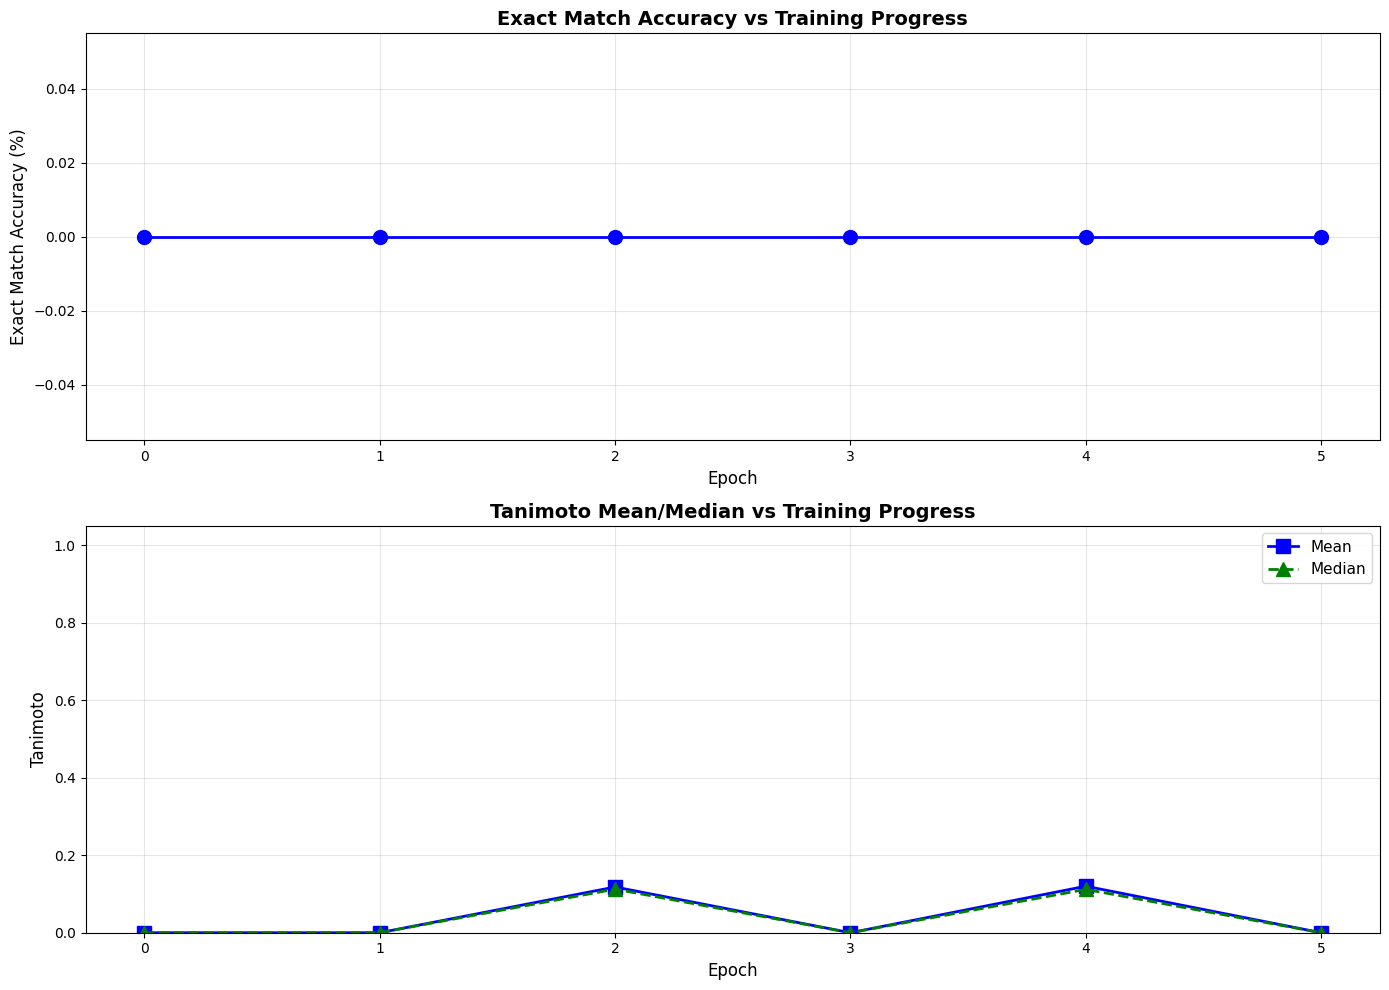

In [40]:
#graph
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Exact match accuracy vs training step
ax1 = axes[0]
ax1.plot(checkpoint_df['epoch'], checkpoint_df['exact_match'] * 100,
         'o-', color='blue', linewidth=2, markersize=10)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Exact Match Accuracy (%)', fontsize=12)
ax1.set_title('Exact Match Accuracy vs Training Progress', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(checkpoint_df['epoch'])

# Tanimoto mean/median vs training step
ax2 = axes[1]
ax2.plot(checkpoint_df['epoch'], checkpoint_df['mean_tanimoto'],
         's-', color='blue', linewidth=2, markersize=10, label='Mean')
ax2.plot(checkpoint_df['epoch'], checkpoint_df['median_tanimoto'],
         '^--', color='green', linewidth=2, markersize=10, label='Median')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Tanimoto', fontsize=12)
ax2.set_title('Tanimoto Mean/Median vs Training Progress', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(checkpoint_df['epoch'])
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()